In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from keras.layers import Reshape,LeakyReLU,Input,Conv2D,UpSampling2D,Dense,Dropout,Flatten
from keras.models import Model,Sequential
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1,l1_l2
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

In [7]:
K.set_image_dim_ordering('th')

# th : (depth,input,rows,columns)
# tf: (rows,columns,input,depth)

np.random.seed(1000)

randomDim = 100

In [8]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()
## now we want the range from -1 to +1 for normalization

X_train = (X_train.astype(np.float32) -127.5) / 127.5 #[-1,1]
X_train = X_train.reshape(60000,784) # 28 * 28


In [10]:
adam = Adam(lr=0.0002,beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
generator = Sequential()
generator.add(Dense(256,input_dim = randomDim))
generator.add(LeakyReLU(0.2)) # 0.2 means that it's slope of cofficient, so the negative line has slope only 20%

generator.add(Dense(512))
generator.add(LeakyReLU(0.2)) 

generator.add(Dense(1024))
generator.add(LeakyReLU(0.2)) 

generator.add(Dense(784,activation='tanh')) ## it should be same as the input of mnist

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [12]:
discriminator = Sequential()
discriminator.add(Dense(1024,input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(1,activation='sigmoid')) ## Here output dimensiomnn will be 1 as it is classification
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
___________________________

In [ ]:
# pehle discriminator ko True karte and baad me false karke pore model ki trainung karemge

In [13]:
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)

gan = Model(input=ganInput,output=ganOutput)
gan.compile(loss='binary_crossentropy',optimizer=adam)
gan.summary()

C:\Users\Raghav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 2,946,577
Non-trainable params: 0
_________________________________________________________________


In [15]:
def plotGeneratedImages(epoch,examples=100,dim=(10,10),figsize=(10,10)):
    noise = np.random.normal(0,1,size=[examples,randomDim])
    generatedImages = generator.predict(noise) ## it is flatten as 784, so we have to make it reshape
    generatedImages = generatedImages.reshape(examples,28,28)
    
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generatedImages[i],interpolation='nearest',cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    

In [16]:
def train(epochs=1,batchSize=128):
    m = X_train.shape[0]
    batchCount = X_train.shape[0] //batchSize  ## ki 1 epoch m kitne batch train ho rhe hai
    plotGeneratedImages(0,)
    for e in range(1,epochs+1):
        for _ in tqdm(range(batchCount)):
            noise = np.random.normal(0,1,size=[batchSize,randomDim])  ## mean 0 ansd std =1, 128 image generate hogye fake wale
            generatedImages = generator.predict(noise)
            
            imageBatch = X_train[np.random.randint(0,m,size=batchSize)]
            X = np.concatenate([imageBatch,generatedImages]) ## 128 are real and 128 are fake
            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9 ## to prevent over confidence, onse-sided label smoothing
            
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X,yDis)
            
            discriminator.trainable = False
            noise = np.random.normal(0,1,size=[batchSize,randomDim])
            yGen = np.ones(batchSize)
            gloss = gan.train_on_batch(noise,yGen)
            ## here gan is compolete model     
        if e%10 ==0:
            plotGeneratedImages(e)

  0%|                                                  | 0/468 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


C:\Users\Raghav\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
 96%|██████████████████████████████████████▌ | 451/468 [01:58<00:04,  3.53it/s]

KeyboardInterrupt: 

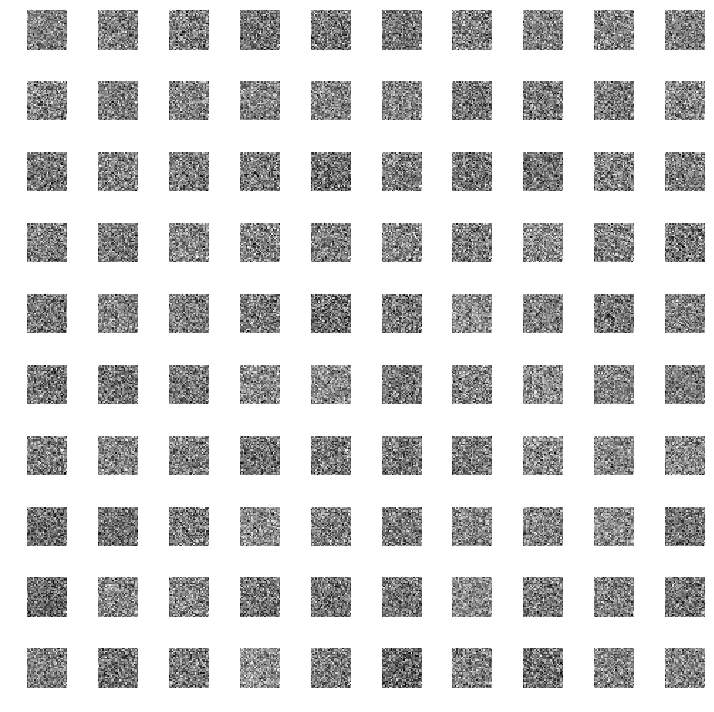

In [17]:
train(50)